In [1]:
import numpy as np
import cv2 as cv
import os
import time
import pandas as pd
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import (StratifiedKFold, train_test_split, 
                                     GridSearchCV, cross_val_score)

In [2]:
data_train = pd.read_csv('../input/digit-recognizer/train.csv')
data_test = pd.read_csv('../input/digit-recognizer/test.csv')
data_sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

In [3]:
data_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data_sub.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


### Preprocessing

In [6]:
# Separate label column on data_train and convert dataframe to a numpy array
image_train = data_train.drop(['label'], axis=1).to_numpy()
label_train = data_train['label'].to_numpy()
image_test = data_test.to_numpy()

print('shape image_train : {}'.format(image_train.shape))
print('shape label : {}'.format(label_train.shape))
print('shape image_test : {}'.format(image_test.shape))

shape image_train : (42000, 784)
shape label : (42000,)
shape image_test : (28000, 784)


In [7]:
# reshape
image_train = image_train.reshape(-1, 28, 28)
image_test = image_test.reshape(-1, 28, 28)

print('shape image : {}'.format(image_train.shape))
print('shape image : {}'.format(image_test.shape))

shape image : (42000, 28, 28)
shape image : (28000, 28, 28)


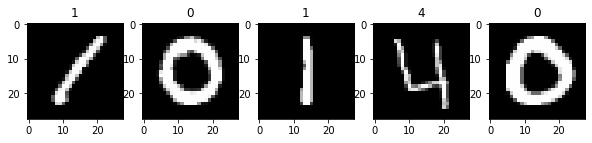

In [8]:
# Plotting
fig = plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1), plt.imshow(image_train[i], cmap='gray')
    plt.title(label_train[i])
plt.show()

### Feature descriptor

In [9]:
# HOG
def hog_descriptor(images): 
    hog_fd = []
    hog_img = []
    for sample in images:
        fd, img = hog(sample, orientations=9,
                      pixels_per_cell=(8, 8), cells_per_block=(2,2), 
                      visualize=True, multichannel=False, feature_vector=True)

        hog_fd.append(fd)
        hog_img.append(img)

    hog_array = np.array(hog_fd, np.float32)
    vis_array = np.array(hog_img)
    print(hog_array.shape)
    return hog_array, vis_array


In [10]:
hog_train, vis_train = hog_descriptor(image_train)
hog_test, vis_test = hog_descriptor(image_test)

(42000, 144)
(28000, 144)


### Model

In [11]:
# Split dataset
x_train, x_val, y_train, y_val = train_test_split(hog_train, label_train, 
                                                  stratify=label_train, 
                                                  shuffle=True,
                                                  random_state=0,
                                                  test_size=0.2)

print(x_train.shape)
print(x_val.shape)

(33600, 144)
(8400, 144)


In [12]:
### multi SVM
svc = SVC(probability=True)

svc.fit(x_train, y_train)    # fit
y_pred_train = svc.predict(x_train)    # predict
y_pred_val = svc.predict(x_val)

# Classification report
print('\nclassification report training : \n', classification_report(y_train, y_pred_train))
print('classification report validation : \n', classification_report(y_val, y_pred_val))

# ROC_AUC
pred_prob = svc.predict_proba(x_val)
roc_auc = roc_auc_score(y_val, pred_prob, multi_class='ovo')
print("AUC-ROC : %0.4f" %(roc_auc))


classification report training : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3306
           1       1.00      0.99      0.99      3747
           2       0.98      0.98      0.98      3342
           3       0.98      0.97      0.98      3481
           4       0.98      0.99      0.98      3258
           5       0.99      0.98      0.99      3036
           6       0.99      0.99      0.99      3309
           7       0.98      0.97      0.97      3521
           8       0.97      0.98      0.97      3250
           9       0.97      0.97      0.97      3350

    accuracy                           0.98     33600
   macro avg       0.98      0.98      0.98     33600
weighted avg       0.98      0.98      0.98     33600

classification report validation : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       826
           1       0.99      0.98      0.98       937
     

In [13]:
# Prediction
y_pred_test = svc.predict(hog_test)

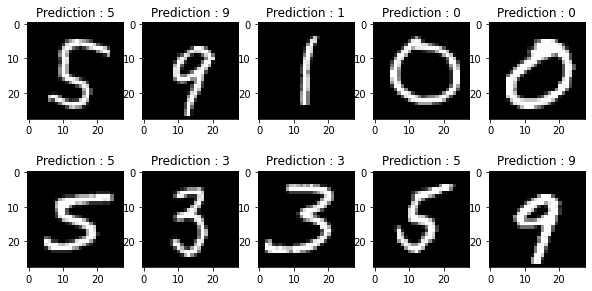

In [17]:
# Plotting
random_number = np.random.randint(image_test.shape[0], size=10)   # random number
fig = plt.figure(figsize=(10,5))
i=0
for num in random_number:
    plt.subplot(2,5,i+1), plt.imshow(image_test[num], cmap='gray')
    plt.title('Prediction : {}'.format(y_pred_test[num]))
    i+=1
plt.show()


### Submission

In [15]:
submission = pd.DataFrame({
    'ImageId':data_sub['ImageId'], 
    'Label':y_pred_test
})
submission.to_csv('Submission.csv',index = False)